In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For Preprocessing
from prog import LabelEncoding, Scaler, OneHotEncoding
from sklearn.pipeline import Pipeline

import lightgbm
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, max_error
from prog import draw_feature_impot_catboost, draw_feature_impot

import warnings
warnings.filterwarnings('ignore')

## What I do?
Steps:
1. Look at data and make all features usable for models.
2. Try to find the best model by selected metrics.
3. Analyze results.

***Step 1.*** I see data with numeric and text columns. Features sex and smoker are binary, so I will use label encoding to encode them; feature region is not binary and I can't find correct labels for it, so I will use one hot encoding for it. Also, I can use a scaler to numeric features (I use standard scaler). Realization of classes with preprocessing you can find in file prog.py, usage of these classes you can find in file choose_model.ipynb. Also, I check correlations between features to find preliminary identify the factors with the highest impact.

***Step 2.*** Then I use different regressors to find the best solution for this task. How I choose metric you can read below, the realization of choosing models - in file choose_model.ipynb

***Step 3*** Analysis of the results is, for example, identifying the factors with the highest impact. The realization you can find below.


## Check correlations

In [2]:
# load csv
data = pd.read_csv('data/insurance.csv')
data.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [3]:
# pipeline to use ohe and le
pipe = Pipeline(steps=[('le', LabelEncoding()),
                       ('ohe', OneHotEncoding())])
pipe.fit_transform(data).head(3)

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.90,0,1,16884.9240,0.0,0.0,0.0,1.0
1,18,1,33.77,1,0,1725.5523,0.0,0.0,1.0,0.0
2,28,1,33.00,3,0,4449.4620,0.0,0.0,1.0,0.0


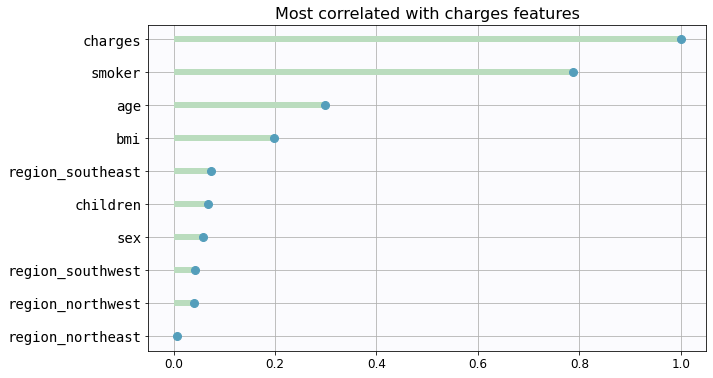

In [4]:
draw_feature_impot(pipe.fit_transform(data).corr(), 
                   np.abs(pipe.fit_transform(data).corr().charges), 
                   title='Most correlated with charges features')

##### As you see most correlate with charges (excluding charges) feature smoker, presumably it will influence the result most of all.

## Get the result of used model

#### As metric I can use:
- $RMSE$ - root of mean squared error. It represents the sample standard deviation of the differences between predicted values and residuals
- $MAE$ - median absolute error. It represents the average of the absolute difference between the predicted values and observed value.
- $R^2$ - the proportion of the variance in the dependent variable that is predictable from the independent variable. To understand look at formula:

$R^2 = 1 - {{SS_{res}}\over {SS_{tot}}}$, where $SS_{res}$ - sum of squares of residuals, $SS_{tot}$ - sum of squares of deviation $y_{true}$ from mean

As you can see from the definition of these metrics: maximum value of $R^2$ is 1, minimum - infinity, range of RMSE and MAE is from 0 to infinity, so they don't tell how bad a model is. Also to get more interpretation results you should use MAE - it simple to analyze because of first pow under sum and of sum at all.

Also you can analyze $max\_error$ - maximum value in reiduals.

All of these metrics you can find in sklearn.metrics.

In [9]:
# use the same seed to get the same results
(X_train, X_valid,
 y_train, y_valid) = train_test_split(data.drop('charges', axis=1),
                                     data.charges, shuffle=True,
                                     test_size=0.2, random_state=42)

In [10]:
bst = lightgbm.Booster(model_file='lightgbm_model.mdl')
prepr = Pipeline(steps=[('le', LabelEncoding()),
                       ('ohe', OneHotEncoding())])
prepr.fit(X_train)
X_valid = prepr.transform(X_valid)

print(f'R2 - {r2_score(y_valid, bst.predict(X_valid)):.4}')
print(f'MRSE - {np.sqrt(mean_squared_error(y_valid, bst.predict(X_valid))):.5}')
print(f'MAE - {median_absolute_error(y_valid, bst.predict(X_valid)):.5}')
print(f'Max error - {max_error(y_valid, bst.predict(X_valid)):.6}')

R2 - 0.8833
MRSE - 4256.1
MAE - 1405.0
Max error - 21210.1


#### Feature importance
Than draw feature importanse plot using matplotlib and catboost method get_feature_importance().

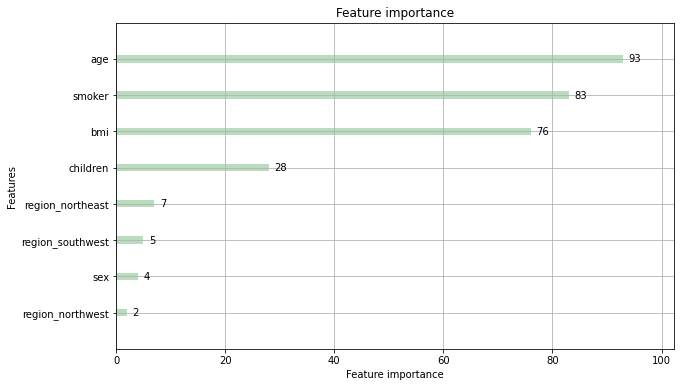

In [7]:
lightgbm.plot_importance(bst, figsize=(10, 6), color='#badcbe');

As expected, one of most impact features is smoker, but bmi and age, which in the second and third places in correlation check, have higher impact than expected.